#Installing Necessary Libraries

In [ ]:
# Install necessary libraries
!pip install transformers[torch]
!pip install torch
!pip install datasets
!pip install accelerate -U
!pip install memory_profiler
!pip install matplotlib seaborn
!pip install peft
# Determine the device
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!pip install imbalanced-learn

# Continue with the rest of the imports
import pandas as pd
import re
import time  # Import time module
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_callback import TrainerState, EarlyStoppingCallback
import time
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import EvalPrediction
from datasets import load_metric
from peft import LoraConfig, get_peft_model

# 1. Cleaning the data

In [ ]:
import pandas as pd
import re
from transformers import DistilBertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

def clean_text(text):
    """
    Cleans input text by removing URLs, mentions, hashtags, emojis, non-ASCII characters, and digits.
    Converts text to lowercase.

    Args:
    text (str): The input string.

    Returns:
    str: The cleaned text.
    """
    ## Return empty string if input is not a string (handles NaN values)
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove emojis and other non-alphanumeric characters
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# 2. Loading the datasets

In [ ]:
# Load existing datasets
gpt_df = pd.read_csv('https://collegecm.blob.core.windows.net/mentalhealthdataset/similar_text_generated_August.csv')

gpt_df['cleaned_text'] = gpt_df['text'].apply(clean_text)
gpt_df['label'] = gpt_df['label'].astype(int)
gpt_df = gpt_df[['cleaned_text', 'label']]

train_df = pd.read_csv('https://collegecm.blob.core.windows.net/mentalhealthdataset/dreaddit-train.csv')
test_df = pd.read_csv('https://collegecm.blob.core.windows.net/mentalhealthdataset/dreaddit-test.csv')


train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['label'] = test_df['label'].astype(int)
train_df['label'] = train_df['label'].astype(int)
train_df = train_df[['cleaned_text', 'label']]
test_df = test_df[['cleaned_text', 'label']]

In [ ]:
# Combine the datasets
combined_df = pd.concat([train_df, test_df, gpt_df], ignore_index=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
print(combined_df['label'].value_counts())


label
0    2500
1    2500
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(combined_df, test_size=0.3, random_state=42, stratify=combined_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Training Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")
print(f"Test Set Size: {len(test_df)}")

Training Set Size: 3500
Validation Set Size: 750
Test Set Size: 750


In [ ]:
def tokenize_data(df):
    return tokenizer(df['cleaned_text'].tolist(), add_special_tokens=True, max_length=512, padding='max_length', truncation=True, return_tensors='pt')

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

# Creating Datasets and DataLoader for Training and Testing

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class MentalHealthDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
#Defines a custom dataset class inheriting from PyTorch's Dataset. It handles the loading of tokenized text data and labels for training and testing.


train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)
test_dataset = MentalHealthDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#Metrics


In [ ]:
from transformers import EvalPrediction
from datasets import load_metric

accuracy_metric = load_metric("accuracy", trust_remote_code=True)
precision_metric = load_metric("precision", trust_remote_code=True)
recall_metric = load_metric("recall", trust_remote_code=True)
f1_metric = load_metric("f1", trust_remote_code=True)


def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = preds.argmax(-1)
    labels = p.label_ids
        # Compute cross-entropy loss
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(torch.tensor(p.predictions, dtype=torch.float32), torch.tensor(p.label_ids, dtype=torch.long)).item()

    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    precision = precision_metric.compute(predictions=preds, references=labels, average='binary')
    recall = recall_metric.compute(predictions=preds, references=labels, average='binary')
    f1 = f1_metric.compute(predictions=preds, references=labels, average='binary')
    return {"accuracy": accuracy["accuracy"], "precision": precision["precision"], "recall": recall["recall"], "f1": f1["f1"], "eval_loss": loss,  "predictions": preds,  "labels": labels,    }   # Include true labels}
#Loads evaluation metrics which will be used to assess the model's performance after training.

# 3. Model Training

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers.trainer_callback import TrainerState, EarlyStoppingCallback
import time
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Set up logging
logging.basicConfig(level=logging.INFO)

class TimeTrackerTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_times = []  # Initialize a list to store training times for each epoch
        self.metrics_per_epoch = []  # Initialize a list to store metrics per epoch
        self.best_eval_loss = float('inf')  # Track the best eval_loss
        self.best_model_dir = None  # Track the directory of the best model

    def train(self, *args, **kwargs):
        self.model.train()
        train_dataloader = self.get_train_dataloader()
        num_train_epochs = self.args.num_train_epochs
        self.state = TrainerState()
        self.state.epoch = 0
        self.state.global_step = 0

        self.create_optimizer()
        self.create_scheduler(num_training_steps=len(train_dataloader) * num_train_epochs)

        for epoch in range(num_train_epochs):
            print(f"\nStarting epoch {epoch + 1}/{num_train_epochs}")

            epoch_start_time = time.time()
            for step, batch in enumerate(train_dataloader):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()
                self.lr_scheduler.step()
                self.optimizer.zero_grad()
                self.state.global_step += 1

            epoch_end_time = time.time()
            epoch_elapsed_time = epoch_end_time - epoch_start_time
            self.epoch_times.append(epoch_elapsed_time)

            print(f"Epoch {epoch + 1} completed in {epoch_elapsed_time:.2f} seconds.")

            metrics = self.evaluate()
            metrics["epoch"] = epoch + 1
            self.metrics_per_epoch.append(metrics)
            self.print_metrics(metrics, epoch_elapsed_time)

            if metrics['eval_loss'] < self.best_eval_loss:
                self.best_eval_loss = metrics['eval_loss']
                self.best_model_dir = os.path.join(self.args.output_dir, f"best_model_epoch_{epoch + 1}")
                self.save_model(self.best_model_dir)
                print(f"New best model found for epoch {epoch + 1} with eval_loss {metrics['eval_loss']}")

            self.state.epoch += 1

        print("Training complete.")
        print(f"Loading the best model from {self.best_model_dir}...")

        self.model = DistilBertForSequenceClassification.from_pretrained(self.best_model_dir)
        self.model.to(device)


    def print_metrics(self, metrics, time_elapsed):
        print(f"{'Epoch':<10}{'Loss':<15}{'Accuracy':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}{'Time (s)':<10}")
        print("="*90)
        print(f"{metrics['epoch']:<10}{metrics['eval_loss']:<15.4f}{metrics['eval_accuracy']:<15.4f}{metrics['eval_precision']:<15.4f}{metrics['eval_recall']:<15.4f}{metrics['eval_f1']:<15.4f}{time_elapsed:<10.2f}")
        print("="*90)
        if self.args.load_best_model_at_end:
            print(f"Best model checkpoint based on {self.args.metric_for_best_model}: Epoch {metrics['epoch']}")

# LoRA configuration and model modification
lora_config = LoraConfig(
    r=1,
    lora_alpha=32,
    target_modules=["q_lin", "v_lin"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

#Prevent overfitting
#Task 1. Weight Decay and Dropout.

base_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = get_peft_model(base_model, lora_config)


# Get the names of all layers
layer_names = [name for name, _ in model.named_parameters()]

# Identify the names of the last two layers
second_to_last_param_name = layer_names[-2]
last_param_name = layer_names[-1]

print(f"The second to last layer name is: {second_to_last_param_name}")
print(f"The last layer name is: {last_param_name}")

# Freeze all layers except the last two
for name, param in model.named_parameters():
    if name not in [second_to_last_param_name, last_param_name]:
        param.requires_grad = False
        print(f"Freezing layer: {name}")
    else:
        print(f"Training layer: {name}")





Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The second to last layer name is: base_model.model.classifier.modules_to_save.default.weight
The last layer name is: base_model.model.classifier.modules_to_save.default.bias
Freezing layer: base_model.model.distilbert.embeddings.word_embeddings.weight
Freezing layer: base_model.model.distilbert.embeddings.position_embeddings.weight
Freezing layer: base_model.model.distilbert.embeddings.LayerNorm.weight
Freezing layer: base_model.model.distilbert.embeddings.LayerNorm.bias
Freezing layer: base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.weight
Freezing layer: base_model.model.distilbert.transformer.layer.0.attention.q_lin.base_layer.bias
Freezing layer: base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_A.default.weight
Freezing layer: base_model.model.distilbert.transformer.layer.0.attention.q_lin.lora_B.default.weight
Freezing layer: base_model.model.distilbert.transformer.layer.0.attention.k_lin.weight
Freezing layer: base_model.model.distil

In [ ]:

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=28,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # Ensure the best model is loaded at the end
    metric_for_best_model="eval_loss",  # Use validation loss to determine the best model
    greater_is_better=False  # Lower loss is better
)

# Initialize the customized trainer
trainer = TimeTrackerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Run the training and track the time in seconds
trainer.train()

# Evaluate the model
metrics = trainer.evaluate(test_dataset)

# Print the final metrics
print(metrics)


Starting epoch 1/28
Epoch 1 completed in 57.42 seconds.


Trainer is attempting to log a value of "[1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1
 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 0 0 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 1 0
 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0
 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 0 0
 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1
 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1
 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1
 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
1         0.6939         0.5027         0.5020         0.6773         0.5766         57.42     
Best model checkpoint based on eval_loss: Epoch 1
New best model found for epoch 1 with eval_loss 0.693920910358429

Starting epoch 2/28
Epoch 2 completed in 58.63 seconds.


Trainer is attempting to log a value of "[1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1
 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0
 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0
 1 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0
 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0
 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
2         0.6861         0.6200         0.5875         0.8053         0.6794         58.63     
Best model checkpoint based on eval_loss: Epoch 2
New best model found for epoch 2 with eval_loss 0.6861022710800171

Starting epoch 3/28
Epoch 3 completed in 58.80 seconds.


Trainer is attempting to log a value of "[1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
3         0.6751         0.6333         0.5784         0.9840         0.7285         58.80     
Best model checkpoint based on eval_loss: Epoch 3
New best model found for epoch 3 with eval_loss 0.6750590801239014

Starting epoch 4/28
Epoch 4 completed in 58.94 seconds.


Trainer is attempting to log a value of "[1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 1 1 1 1
 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0
 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 1
 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
4         0.6637         0.7080         0.6506         0.8987         0.7548         58.94     
Best model checkpoint based on eval_loss: Epoch 4
New best model found for epoch 4 with eval_loss 0.663747251033783

Starting epoch 5/28
Epoch 5 completed in 58.82 seconds.


Trainer is attempting to log a value of "[1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0
 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0
 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1
 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 1 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
5         0.6539         0.7253         0.6622         0.9200         0.7701         58.82     
Best model checkpoint based on eval_loss: Epoch 5
New best model found for epoch 5 with eval_loss 0.6538557410240173

Starting epoch 6/28
Epoch 6 completed in 58.85 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1
 0 1 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
6         0.6445         0.7413         0.6989         0.8480         0.7663         58.85     
Best model checkpoint based on eval_loss: Epoch 6
New best model found for epoch 6 with eval_loss 0.6445302963256836

Starting epoch 7/28
Epoch 7 completed in 58.98 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
7         0.6361         0.7493         0.7046         0.8587         0.7740         58.98     
Best model checkpoint based on eval_loss: Epoch 7
New best model found for epoch 7 with eval_loss 0.6361222863197327

Starting epoch 8/28
Epoch 8 completed in 59.15 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
8         0.6285         0.7547         0.7247         0.8213         0.7700         59.15     
Best model checkpoint based on eval_loss: Epoch 8
New best model found for epoch 8 with eval_loss 0.6284958124160767

Starting epoch 9/28
Epoch 9 completed in 59.16 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 1 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
9         0.6215         0.7493         0.7092         0.8453         0.7713         59.16     
Best model checkpoint based on eval_loss: Epoch 9
New best model found for epoch 9 with eval_loss 0.6215195059776306

Starting epoch 10/28
Epoch 10 completed in 58.93 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
10        0.6154         0.7667         0.7463         0.8080         0.7759         58.93     
Best model checkpoint based on eval_loss: Epoch 10
New best model found for epoch 10 with eval_loss 0.615365207195282

Starting epoch 11/28
Epoch 11 completed in 58.77 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0
 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
11        0.6097         0.7760         0.7731         0.7813         0.7772         58.77     
Best model checkpoint based on eval_loss: Epoch 11
New best model found for epoch 11 with eval_loss 0.6097217798233032

Starting epoch 12/28
Epoch 12 completed in 58.98 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
12        0.6043         0.7680         0.7457         0.8133         0.7781         58.98     
Best model checkpoint based on eval_loss: Epoch 12
New best model found for epoch 12 with eval_loss 0.6042959690093994

Starting epoch 13/28
Epoch 13 completed in 59.15 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1
 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
13        0.5994         0.7547         0.7195         0.8347         0.7728         59.15     
Best model checkpoint based on eval_loss: Epoch 13
New best model found for epoch 13 with eval_loss 0.599433422088623

Starting epoch 14/28
Epoch 14 completed in 58.97 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
14        0.5951         0.7693         0.7463         0.8160         0.7796         58.97     
Best model checkpoint based on eval_loss: Epoch 14
New best model found for epoch 14 with eval_loss 0.5950943827629089

Starting epoch 15/28
Epoch 15 completed in 58.98 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
15        0.5912         0.7693         0.7475         0.8133         0.7791         58.98     
Best model checkpoint based on eval_loss: Epoch 15
New best model found for epoch 15 with eval_loss 0.5911710262298584

Starting epoch 16/28
Epoch 16 completed in 59.02 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
16        0.5876         0.7720         0.7512         0.8133         0.7810         59.02     
Best model checkpoint based on eval_loss: Epoch 16
New best model found for epoch 16 with eval_loss 0.5876340866088867

Starting epoch 17/28
Epoch 17 completed in 58.80 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
17        0.5844         0.7720         0.7488         0.8187         0.7822         58.80     
Best model checkpoint based on eval_loss: Epoch 17
New best model found for epoch 17 with eval_loss 0.5843563079833984

Starting epoch 18/28
Epoch 18 completed in 58.76 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
18        0.5815         0.7693         0.7428         0.8240         0.7813         58.76     
Best model checkpoint based on eval_loss: Epoch 18
New best model found for epoch 18 with eval_loss 0.5814900994300842

Starting epoch 19/28
Epoch 19 completed in 58.71 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
19        0.5790         0.7707         0.7482         0.8160         0.7806         58.71     
Best model checkpoint based on eval_loss: Epoch 19
New best model found for epoch 19 with eval_loss 0.5789914131164551

Starting epoch 20/28
Epoch 20 completed in 58.82 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
20        0.5767         0.7707         0.7470         0.8187         0.7812         58.82     
Best model checkpoint based on eval_loss: Epoch 20
New best model found for epoch 20 with eval_loss 0.5767390131950378

Starting epoch 21/28
Epoch 21 completed in 58.97 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
21        0.5748         0.7733         0.7482         0.8240         0.7843         58.97     
Best model checkpoint based on eval_loss: Epoch 21
New best model found for epoch 21 with eval_loss 0.5747976303100586

Starting epoch 22/28
Epoch 22 completed in 59.01 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
22        0.5732         0.7733         0.7482         0.8240         0.7843         59.01     
Best model checkpoint based on eval_loss: Epoch 22
New best model found for epoch 22 with eval_loss 0.5731579065322876

Starting epoch 23/28
Epoch 23 completed in 59.07 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
23        0.5718         0.7733         0.7482         0.8240         0.7843         59.07     
Best model checkpoint based on eval_loss: Epoch 23
New best model found for epoch 23 with eval_loss 0.5717660784721375

Starting epoch 24/28
Epoch 24 completed in 59.09 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
24        0.5706         0.7693         0.7463         0.8160         0.7796         59.09     
Best model checkpoint based on eval_loss: Epoch 24
New best model found for epoch 24 with eval_loss 0.5706490278244019

Starting epoch 25/28
Epoch 25 completed in 58.97 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
25        0.5698         0.7733         0.7482         0.8240         0.7843         58.97     
Best model checkpoint based on eval_loss: Epoch 25
New best model found for epoch 25 with eval_loss 0.5697680115699768

Starting epoch 26/28
Epoch 26 completed in 58.73 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
26        0.5691         0.7693         0.7463         0.8160         0.7796         58.73     
Best model checkpoint based on eval_loss: Epoch 26
New best model found for epoch 26 with eval_loss 0.5691499710083008

Starting epoch 27/28
Epoch 27 completed in 59.02 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
27        0.5688         0.7707         0.7470         0.8187         0.7812         59.02     
Best model checkpoint based on eval_loss: Epoch 27
New best model found for epoch 27 with eval_loss 0.5687745213508606

Starting epoch 28/28
Epoch 28 completed in 58.91 seconds.


Trainer is attempting to log a value of "[1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1
 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0
 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0
 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0
 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 1 1
 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 

Epoch     Loss           Accuracy       Precision      Recall         F1 Score       Time (s)  
28        0.5686         0.7707         0.7470         0.8187         0.7812         58.91     
Best model checkpoint based on eval_loss: Epoch 28
New best model found for epoch 28 with eval_loss 0.5686435699462891
Training complete.
Loading the best model from ./results/best_model_epoch_28...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer is attempting to log a value of "[1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1
 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1
 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 1
 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0
 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1
 0 1 1

{'eval_loss': 0.5822716355323792, 'eval_accuracy': 0.7493333333333333, 'eval_precision': 0.7139588100686499, 'eval_recall': 0.832, 'eval_f1': 0.7684729064039408, 'eval_predictions': array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0,

In [ ]:
training_times = trainer.epoch_times  # Get recorded training times
print(f"Training Times: {training_times}")

Training Times: [57.41511535644531, 58.632973194122314, 58.799275159835815, 58.94340419769287, 58.822184324264526, 58.846975564956665, 58.97930836677551, 59.15292716026306, 59.158364057540894, 58.929999113082886, 58.76804327964783, 58.98263144493103, 59.152360677719116, 58.97008037567139, 58.9791157245636, 59.019989252090454, 58.80178737640381, 58.76215219497681, 58.705275535583496, 58.823243856430054, 58.96663761138916, 59.009730100631714, 59.07221794128418, 59.08829307556152, 58.96781063079834, 58.73197364807129, 59.01843810081482, 58.90579056739807]


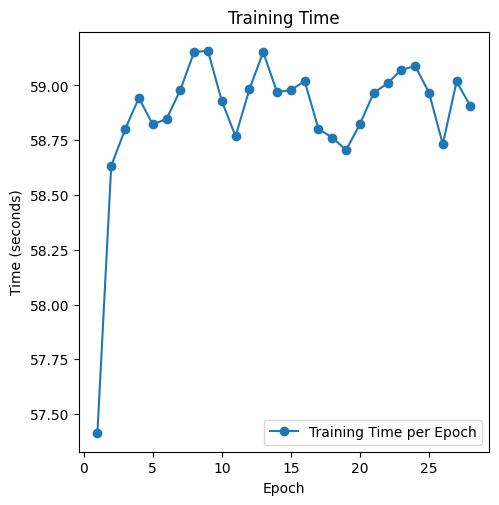

In [ ]:
epochs = list(range(1, len(trainer.epoch_times) + 1))
training_times = trainer.epoch_times  # Get recorded training times

plt.figure(figsize=(18, 12))

# Plot training time per epoch
plt.subplot(2, 3, 1)
plt.plot(epochs, training_times, marker='o', label='Training Time per Epoch')
plt.title('Training Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

In [ ]:
# Extract accuracy metrics for visualization
accuracy = [metrics['eval_accuracy'] for metrics in trainer.metrics_per_epoch]
precision = [metrics['eval_precision'] for metrics in trainer.metrics_per_epoch]
recall = [metrics['eval_recall'] for metrics in trainer.metrics_per_epoch]
f1 = [metrics['eval_f1'] for metrics in trainer.metrics_per_epoch]
eval_losses = [metrics['eval_loss'] for metrics in trainer.metrics_per_epoch]

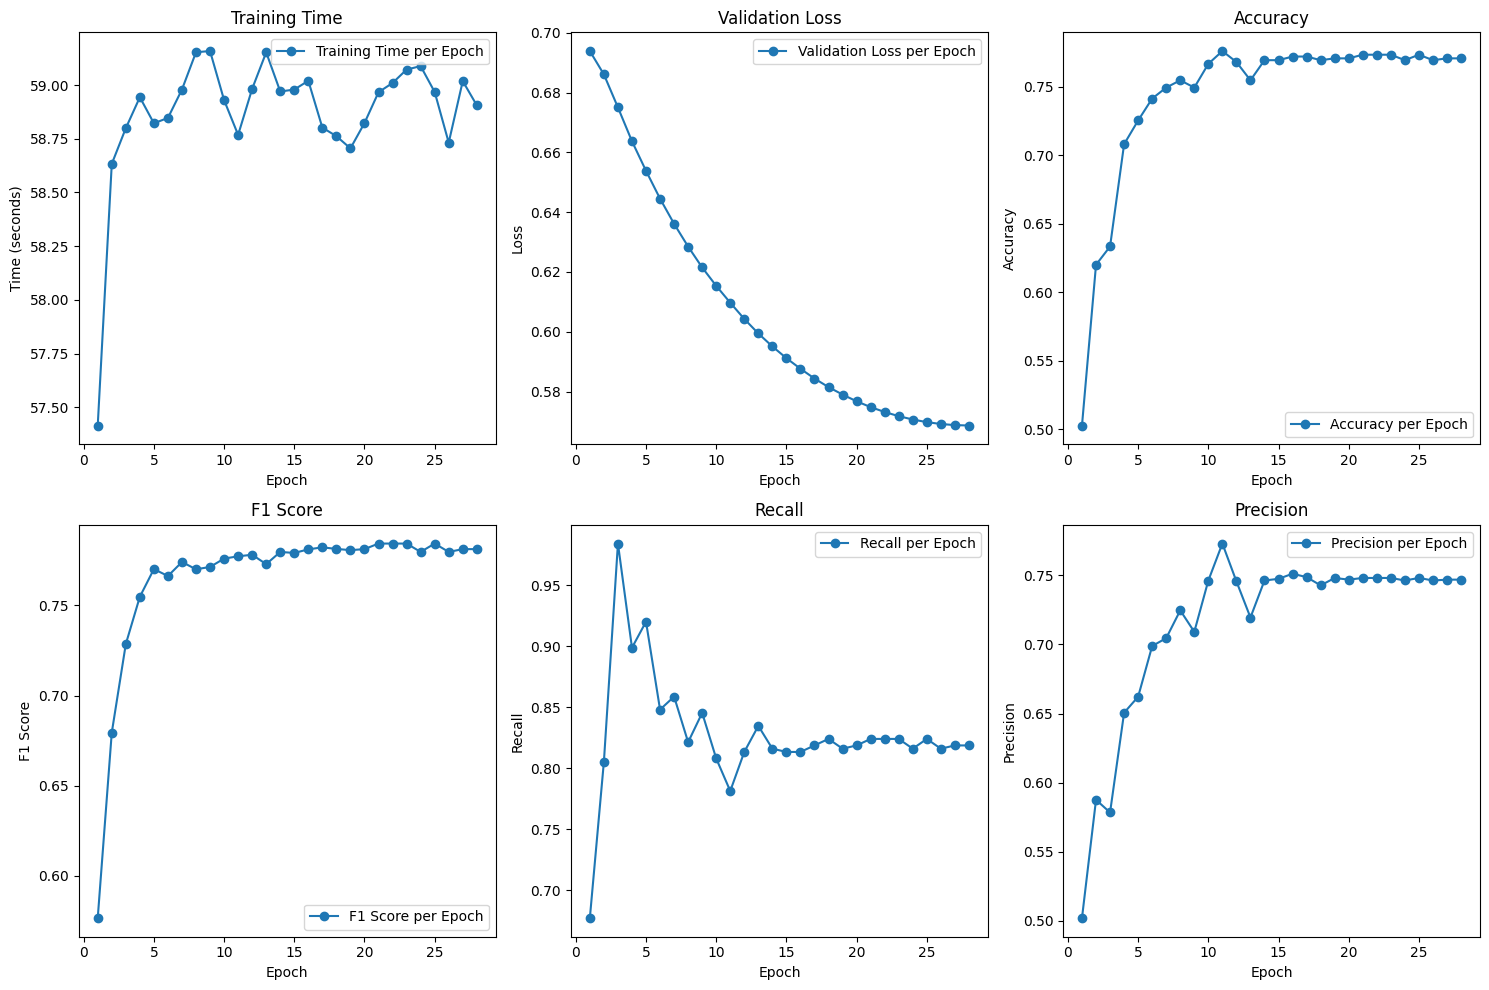

In [ ]:
# Plot the metrics in a 2x3 grid layout
plt.figure(figsize=(15, 10))

# Plot training time per epoch
plt.subplot(2, 3, 1)
plt.plot(epochs, training_times, marker='o', label='Training Time per Epoch')
plt.title('Training Time')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, eval_losses, marker='o', label='Validation Loss per Epoch')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 3, 3)
plt.plot(epochs, accuracy, marker='o', label='Accuracy per Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot F1 score
plt.subplot(2, 3, 4)
plt.plot(epochs, f1, marker='o', label='F1 Score per Epoch')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# Plot recall
plt.subplot(2, 3, 5)
plt.plot(epochs, recall, marker='o', label='Recall per Epoch')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plot precision
plt.subplot(2, 3, 6)
plt.plot(epochs, precision, marker='o', label='Precision per Epoch')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
input_text ="i have this feeling of dread about school right before i go to bed and i wake up with an upset stomach which lasts all day and makes me feel like i'll throw up i'm not sure where else to go with this but i need help if any of you have this can you tell me how you deal with it i'm tired of having this every day and feeling like i'll throw up"

cleaned_text = clean_text(input_text)
print(cleaned_text)

i have this feeling of dread about school right before i go to bed and i wake up with an upset stomach which lasts all day and makes me feel like i'll throw up i'm not sure where else to go with this but i need help if any of you have this can you tell me how you deal with it i'm tired of having this every day and feeling like i'll throw up


In [ ]:
!pip install shap
import shap
import torch
from transformers import DistilBertForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer from your training step
model = DistilBertForSequenceClassification.from_pretrained('./results/best_model_epoch_42')  # Replace with the actual path to your fine-tuned model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a wrapper function for SHAP
class TransformersTextWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predict_proba(self, texts):
        # Ensure the texts are tokenized correctly
        inputs = self.tokenizer(list(texts), return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        outputs = self.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
        return probs

# Initialize the wrapper
wrapper = TransformersTextWrapper(model, tokenizer)

# Create a SHAP explainer using the wrapper's predict_proba method
explainer = shap.Explainer(wrapper.predict_proba, tokenizer)

# Sample text to explain
texts_to_explain = ["i have this feeling of dread about school right before i go to bed and i wake up with an upset stomach which lasts all day and makes me feel like i'll throw up"]

# Generate SHAP values
shap_values = explainer(texts_to_explain)

# Display the SHAP text plot inline
plt.figure(figsize=(12, 8))  # Increase the figure size

shap.plots.text(shap_values[0])



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<Figure size 1200x800 with 0 Axes>

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


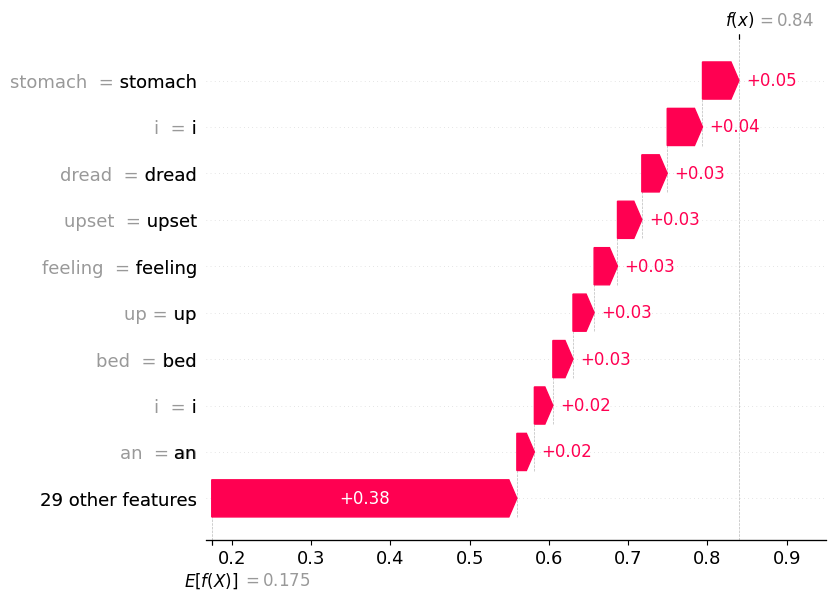

In [ ]:
import shap
import torch
from transformers import DistilBertForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./results/best_model_epoch_42')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Wrapper function for SHAP
class TransformersTextWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predict_proba(self, texts):
        inputs = self.tokenizer(list(texts), return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        outputs = self.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
        return probs

wrapper = TransformersTextWrapper(model, tokenizer)
explainer = shap.Explainer(wrapper.predict_proba, tokenizer)

# Generate SHAP values for a single text
shap_values_single = explainer(["i have this feeling of dread about school right before i go to bed and i wake up with an upset stomach which lasts all day and makes me feel like i'll throw up"])

# Choose a specific class to visualize (e.g., class 0 or 1)
class_to_explain = 1  # Change this to the appropriate class index
shap.waterfall_plot(shap_values_single[0][:, class_to_explain])


In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer
# Determine the device and move the model to that device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to get predictions from the model on the GPU
def predict_gpu(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().cpu().numpy()
    return probs

# Function to get predictions from the model on the CPU
def predict_cpu(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()
    return probs

# Initialize LIME Text Explainer
explainer = LimeTextExplainer(class_names=['Not Mental Health Issue', 'Mental Health Issue'])

# Function to predict on CPU for LIME
def predict_cpu(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {k: v.to('cpu') for k, v in inputs.items()}  # Move inputs to CPU
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1).detach().numpy()
    return probs

# Sample text to explain
texts_to_explain = "i have this feeling of dread about school right before i go to bed and i wake up with an upset stomach which lasts all day and makes me feel like i'll throw up"
texts_to_explain = clean_text(texts_to_explain)

# Moving model to CPU for prediction
model.to('cpu')

# Explain the prediction using the CPU prediction function with increased num_samples
exp = explainer.explain_instance(texts_to_explain, predict_cpu, num_features=20, labels=[1], num_samples=10000)  # Increased from default

# Display the explanation in the notebook
exp.show_in_notebook(text=True)

exp.save_to_file('lime_explanation_mental_health_sample_positive.html')
#files.download('lime_explanation_mental_health_sample_positive.html')
